In [1]:
# https://www.cs.toronto.edu/~kriz/cifar.html
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [3]:
files = unpickle('./data/data_batch_1')
files.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [4]:
data = files[b'data']
labels = files[b'labels']

In [5]:
data.shape

(10000, 3072)

In [6]:
data = data.reshape(10000, 3, 32, 32)
data.shape

(10000, 3, 32, 32)

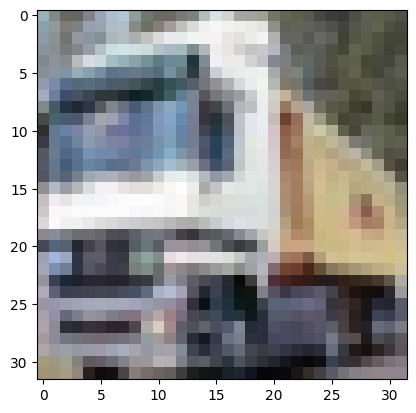

In [7]:
imshow(data[1])

In [8]:
labels[1]

9

In [9]:
classes[labels[1]]

'truck'

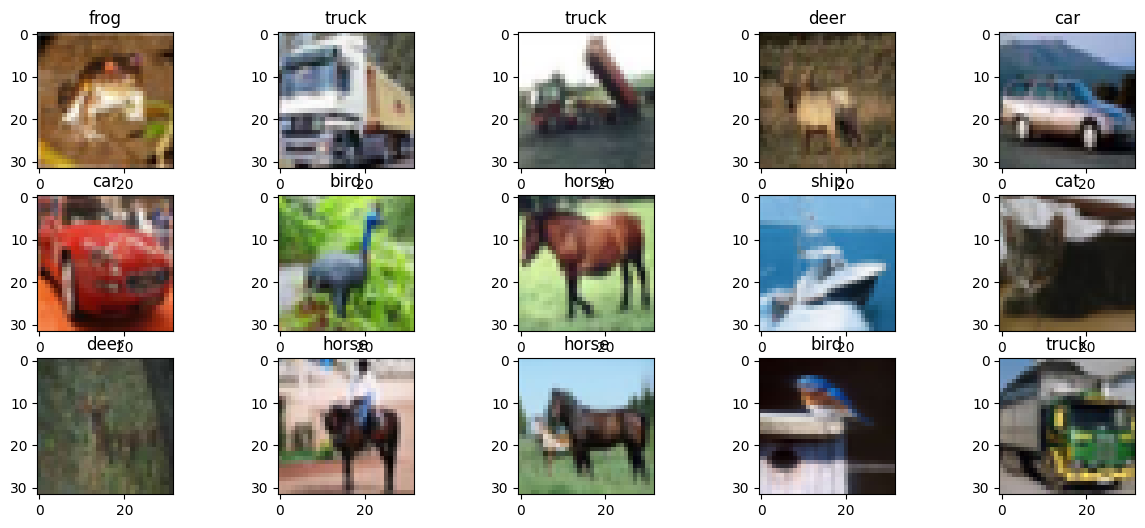

In [10]:
fig, ax = plt.subplots(3, 5, figsize=(15, 6))
idx=0
for i in range(3):
    for j in range(5):
        ax[i, j].imshow(data[idx].transpose(1, 2, 0))
        ax[i, j].set_title(classes[labels[idx]])
        idx += 1

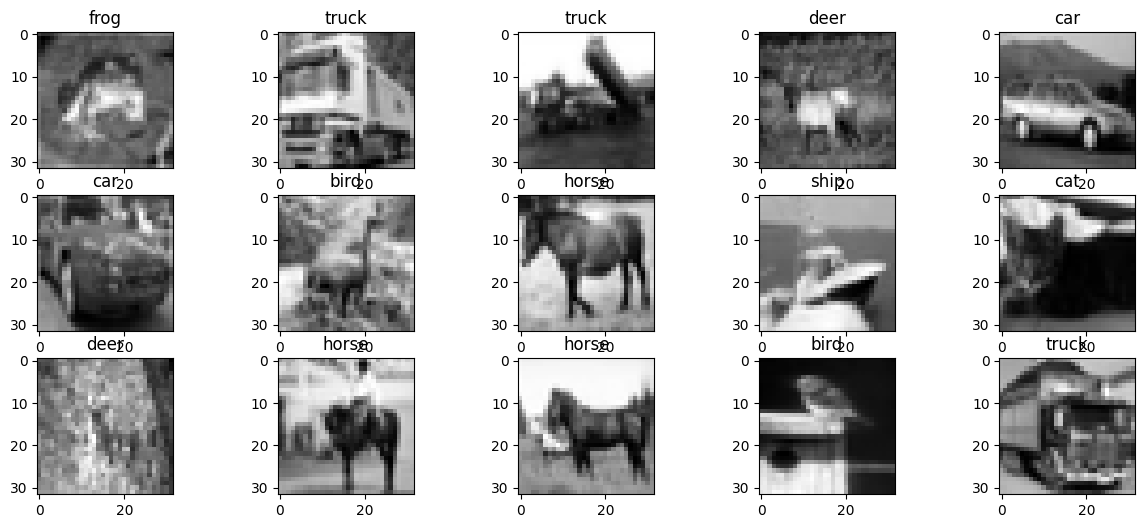

In [11]:
# convert to grayscale
data_gray = np.mean(data, axis=1)
data_gray.shape

idx = 0
fig, ax = plt.subplots(3, 5, figsize=(15, 6))
for i in range(3):
    for j in range(5):
        ax[i, j].imshow(data_gray[idx], cmap='gray')
        ax[i, j].set_title(classes[labels[idx]])
        idx += 1

In [12]:
# merge data_gray and labels
data_gray = data_gray.reshape(10000, 32*32)
print(data_gray.shape)

data_gray = np.hstack((data_gray, np.array(labels).reshape(10000, 1)))
print(data_gray.shape)

# shuffle data
np.random.shuffle(data_gray)
print(data_gray.shape)

# split into train and test
train_data = data_gray[:8000, :-1]
train_labels = data_gray[:8000, -1]
test_data = data_gray[8000:, :-1]
test_labels = data_gray[8000:, -1]

train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

(10000, 1024)
(10000, 1025)
(10000, 1025)


((8000, 1024), (8000,), (2000, 1024), (2000,))

# Building the model

überlegungen: 32*32 -> 1024 Neuronen als Eingangswert

128 Neuronen in der ersten Schicht

128 Neuronen in der zweiten Schicht

10 Neuronen in der letzten Schicht als Ausgangswert

In [13]:
# convert to torch tensors
train_data = torch.from_numpy(train_data).float()
train_labels = torch.from_numpy(train_labels).long()
test_data = torch.from_numpy(test_data).float()
test_labels = torch.from_numpy(test_labels).long()

train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

(torch.Size([8000, 1024]),
 torch.Size([8000]),
 torch.Size([2000, 1024]),
 torch.Size([2000]))

In [14]:
class fully_connected(torch.nn.Module):
    def __init__(self, input_size=1024, hidden_size=128, output_size=10):
        super(fully_connected, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size[0])
        self.fc2 = torch.nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = torch.nn.Linear(hidden_size[1], output_size)

        self.bn1 = torch.nn.BatchNorm1d(hidden_size[0])
        self.bn2 = torch.nn.BatchNorm1d(hidden_size[1])

    def forward(self, xb):
        #print('xb',xb.shape, xb.dtype)
        z2 = self.fc1(xb) # z2 = w1*x + b1
        #print('z2',z2.shape, z2.dtype)
        a2 = torch.relu(z2) # negative values are set to zero
        #print('a2',a2.shape, a2.dtype)
        a2_bn = self.bn1(a2) # batch normalization

        z3 = self.fc2(a2_bn) # z3 = w2*a2 + b2
        #print('z3',z3.shape)
        a3 = torch.relu(z3) 
        #print('a3',a3.shape)
        a3_bn = self.bn2(a3) 

        #print('a2_bn',a2_bn.shape)
        y_hat = torch.relu(self.fc3(a3_bn)) # y_hat = w2*a2 + b2
        #print('y_hat',y_hat.shape)
        return y_hat
    
def get_batch(x, y, batch_size):
    for i in range(0, len(x), batch_size):
        yield x[i:i+batch_size], y[i:i+batch_size]

### without optimizer

100%|██████████| 50/50 [00:02<00:00, 20.23it/s]


0 tensor(0.0673)
1 tensor(0.1176)
2 tensor(0.1078)
3 tensor(0.1111)
4 tensor(0.0872)
5 tensor(0.0990)
6 tensor(0.1111)
7 tensor(0.1630)
8 tensor(0.1080)
9 tensor(0.1485)


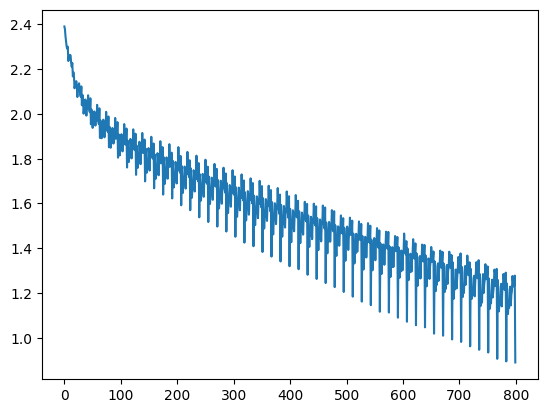

In [15]:
model = fully_connected(input_size=1024, hidden_size=(256, 256), output_size=10)
loss = torch.nn.CrossEntropyLoss()

lr = 0.01
batch_size = 512

def train(xb, yb):
    y_hat = model(xb)
    loss_value = loss(y_hat, yb)
    loss_value.backward()
    with torch.no_grad():
        for p in model.parameters():
            p -= p.grad * lr
        model.zero_grad()
    return loss_value.item()

losses = []
from tqdm import tqdm
for epoch in tqdm(range(50)):
    for xb, yb in get_batch(train_data, train_labels, batch_size):
        loss_value = train(xb, yb)
        losses.append(loss_value)

plt.plot(losses)

# accuracy
def accuracy(xb, yb):
    y_hat = model(xb)
    y_hat = torch.argmax(y_hat, dim=1)
    return (y_hat == yb).float().mean()

accuracy(test_data, test_labels)
# print accuracy for each class
for i in range(10):
    print(i, accuracy(test_data[test_labels==i], test_labels[test_labels==i]))

### with optimizer Adam

100%|██████████| 100/100 [00:03<00:00, 27.00it/s]

0 tensor(0.1058)
1 tensor(0.1283)
2 tensor(0.1250)
3 tensor(0.1014)
4 tensor(0.1128)
5 tensor(0.1139)
6 tensor(0.1546)
7 tensor(0.1087)
8 tensor(0.1307)
9 tensor(0.1535)


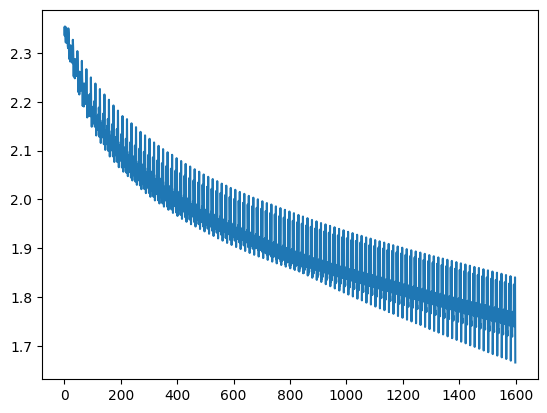

In [16]:
model = fully_connected(input_size=1024, hidden_size=(128, 128), output_size=10)
loss = torch.nn.CrossEntropyLoss()

lr = 0.00001
batch_size = 512
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train(xb, yb):
    y_hat = model(xb)
    loss_value = loss(y_hat, yb)
    loss_value.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss_value.item()

losses = []
from tqdm import tqdm
for epoch in tqdm(range(epochs)):
    for xb, yb in get_batch(train_data, train_labels, batch_size):
        loss_value = train(xb, yb)
        losses.append(loss_value)

plt.plot(losses)

# accuracy
def accuracy(xb, yb):
    y_hat = model(xb)
    y_hat = torch.argmax(y_hat, dim=1)
    return (y_hat == yb).float().mean()

accuracy(test_data, test_labels)
# print accuracy for each class
for i in range(10):
    print(i, accuracy(test_data[test_labels==i], test_labels[test_labels==i]))

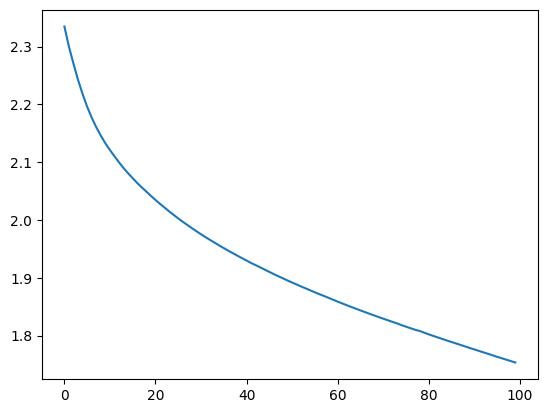

In [18]:
# smooth the loss curve
losses = np.array(losses)
losses = losses.reshape(epochs, -1)
losses = losses.mean(axis=1)
plt.plot(losses)

(1348,)


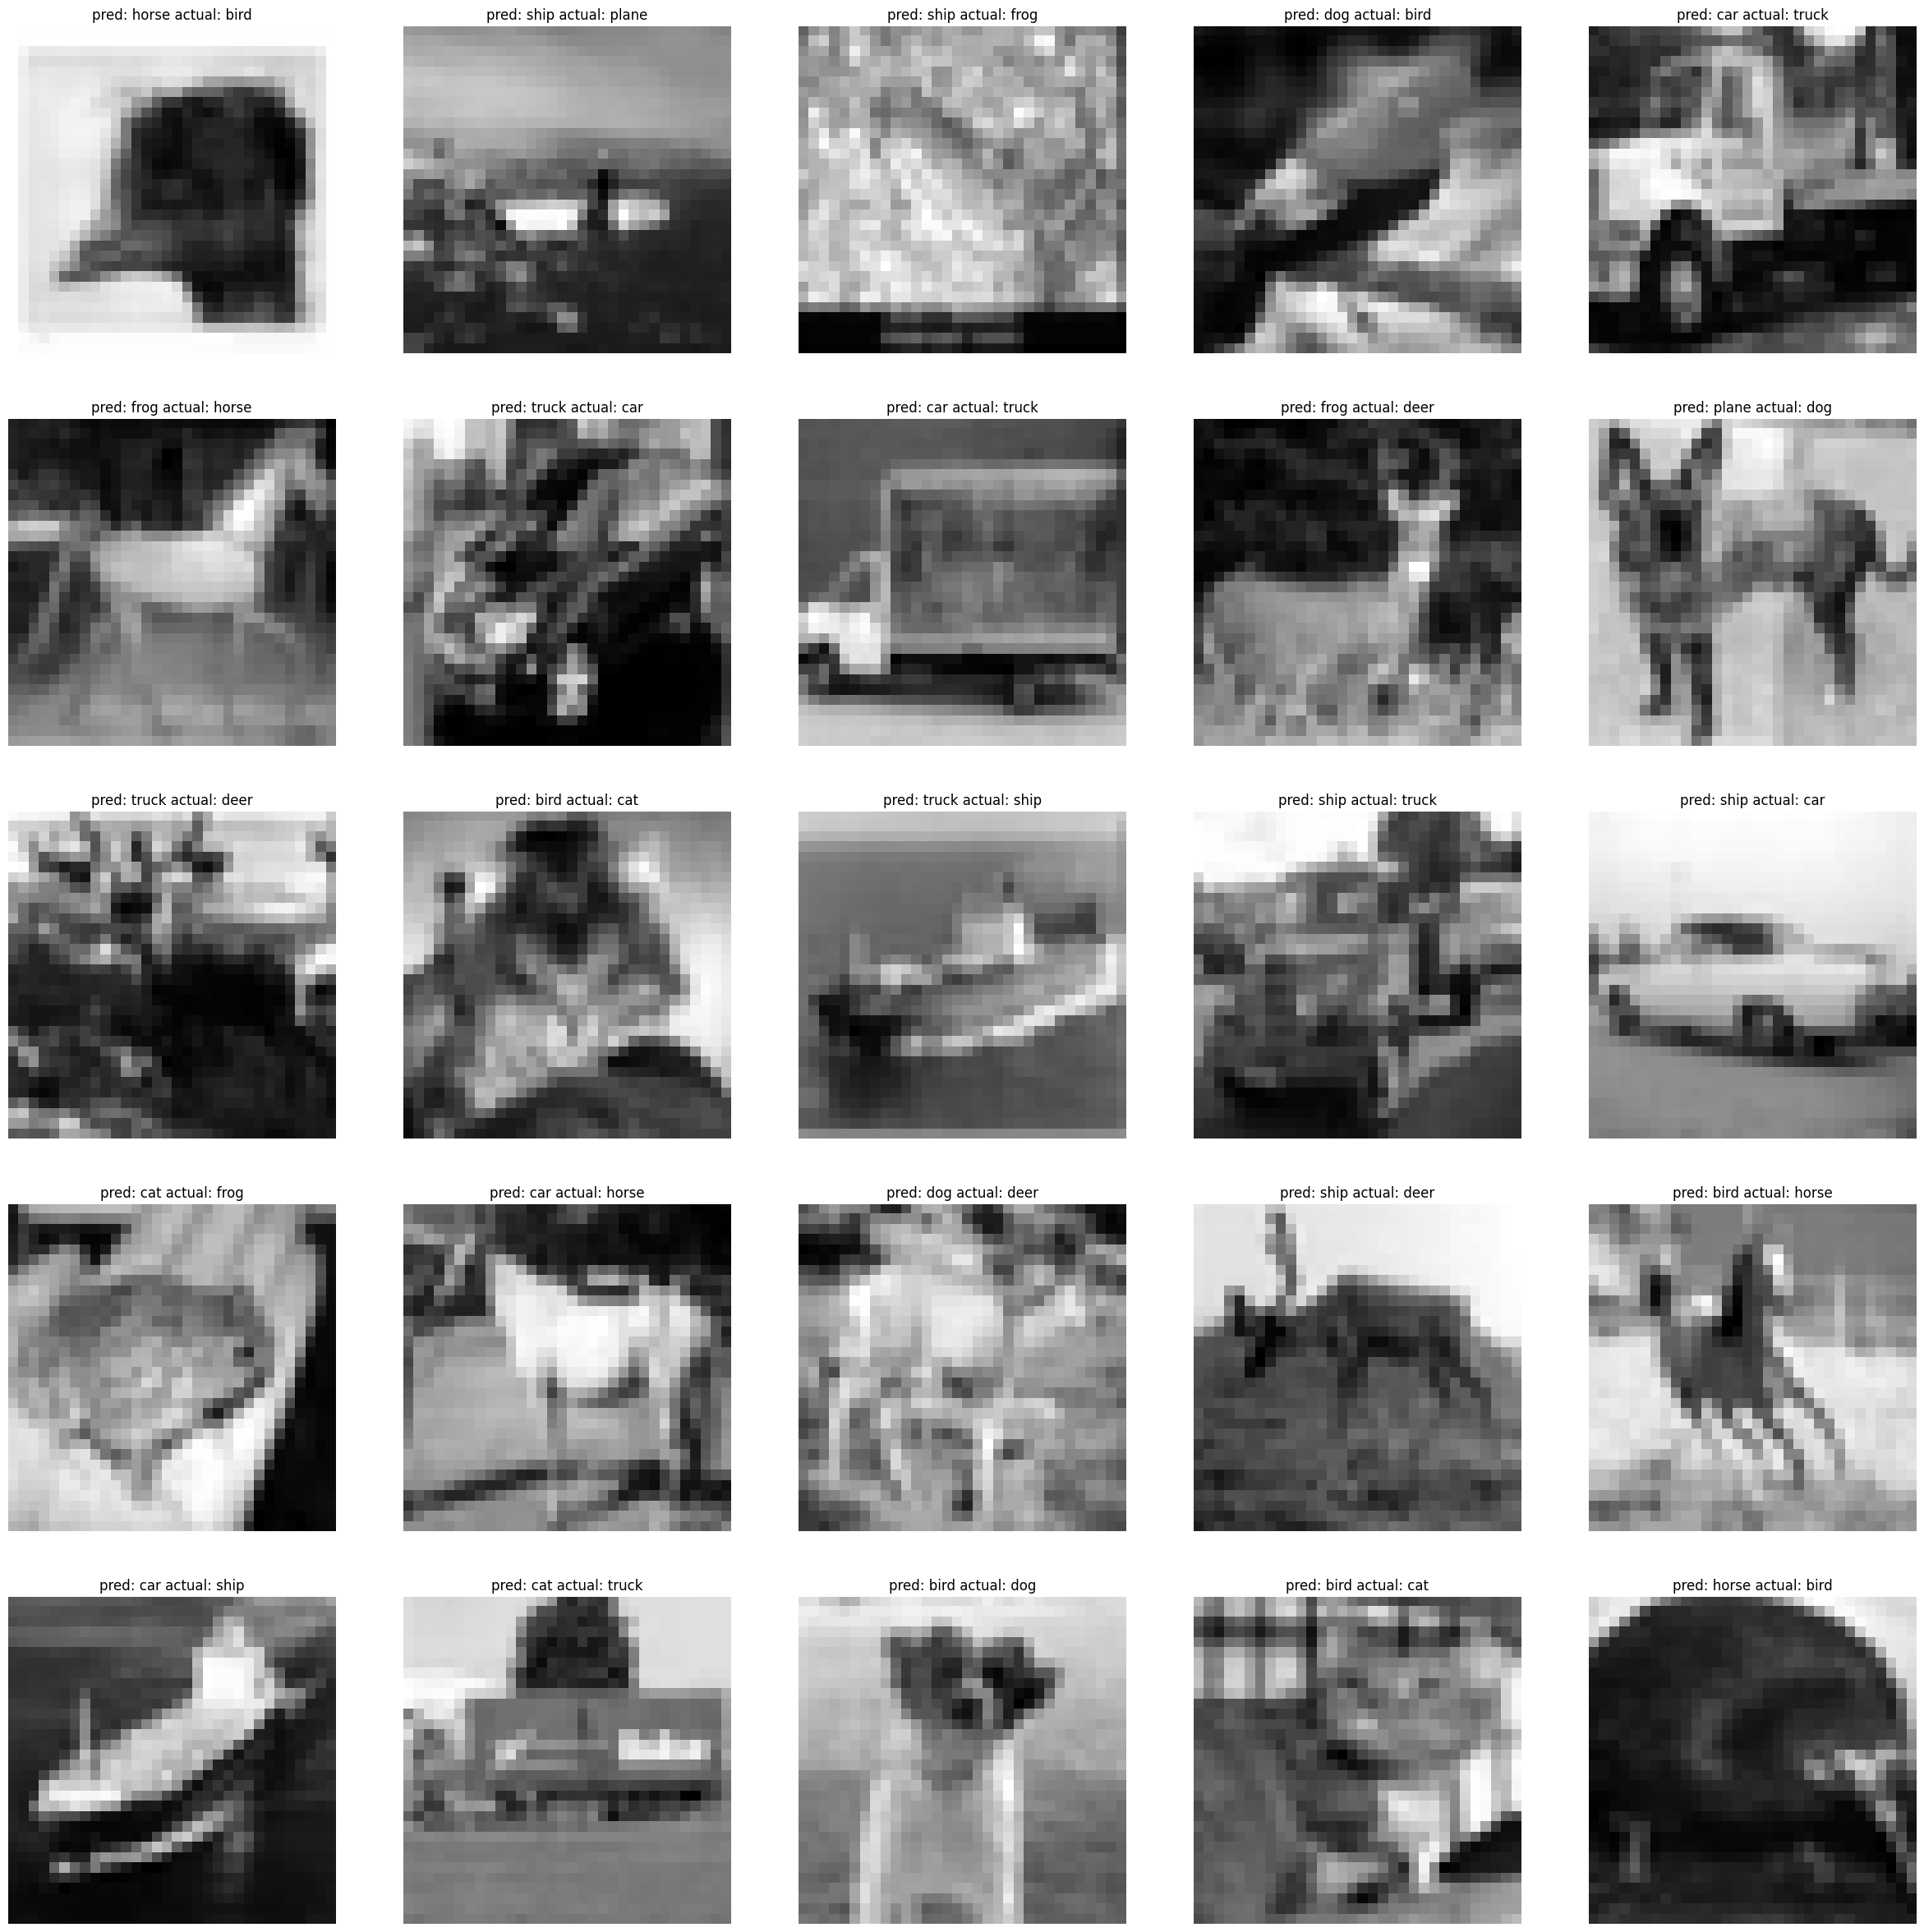

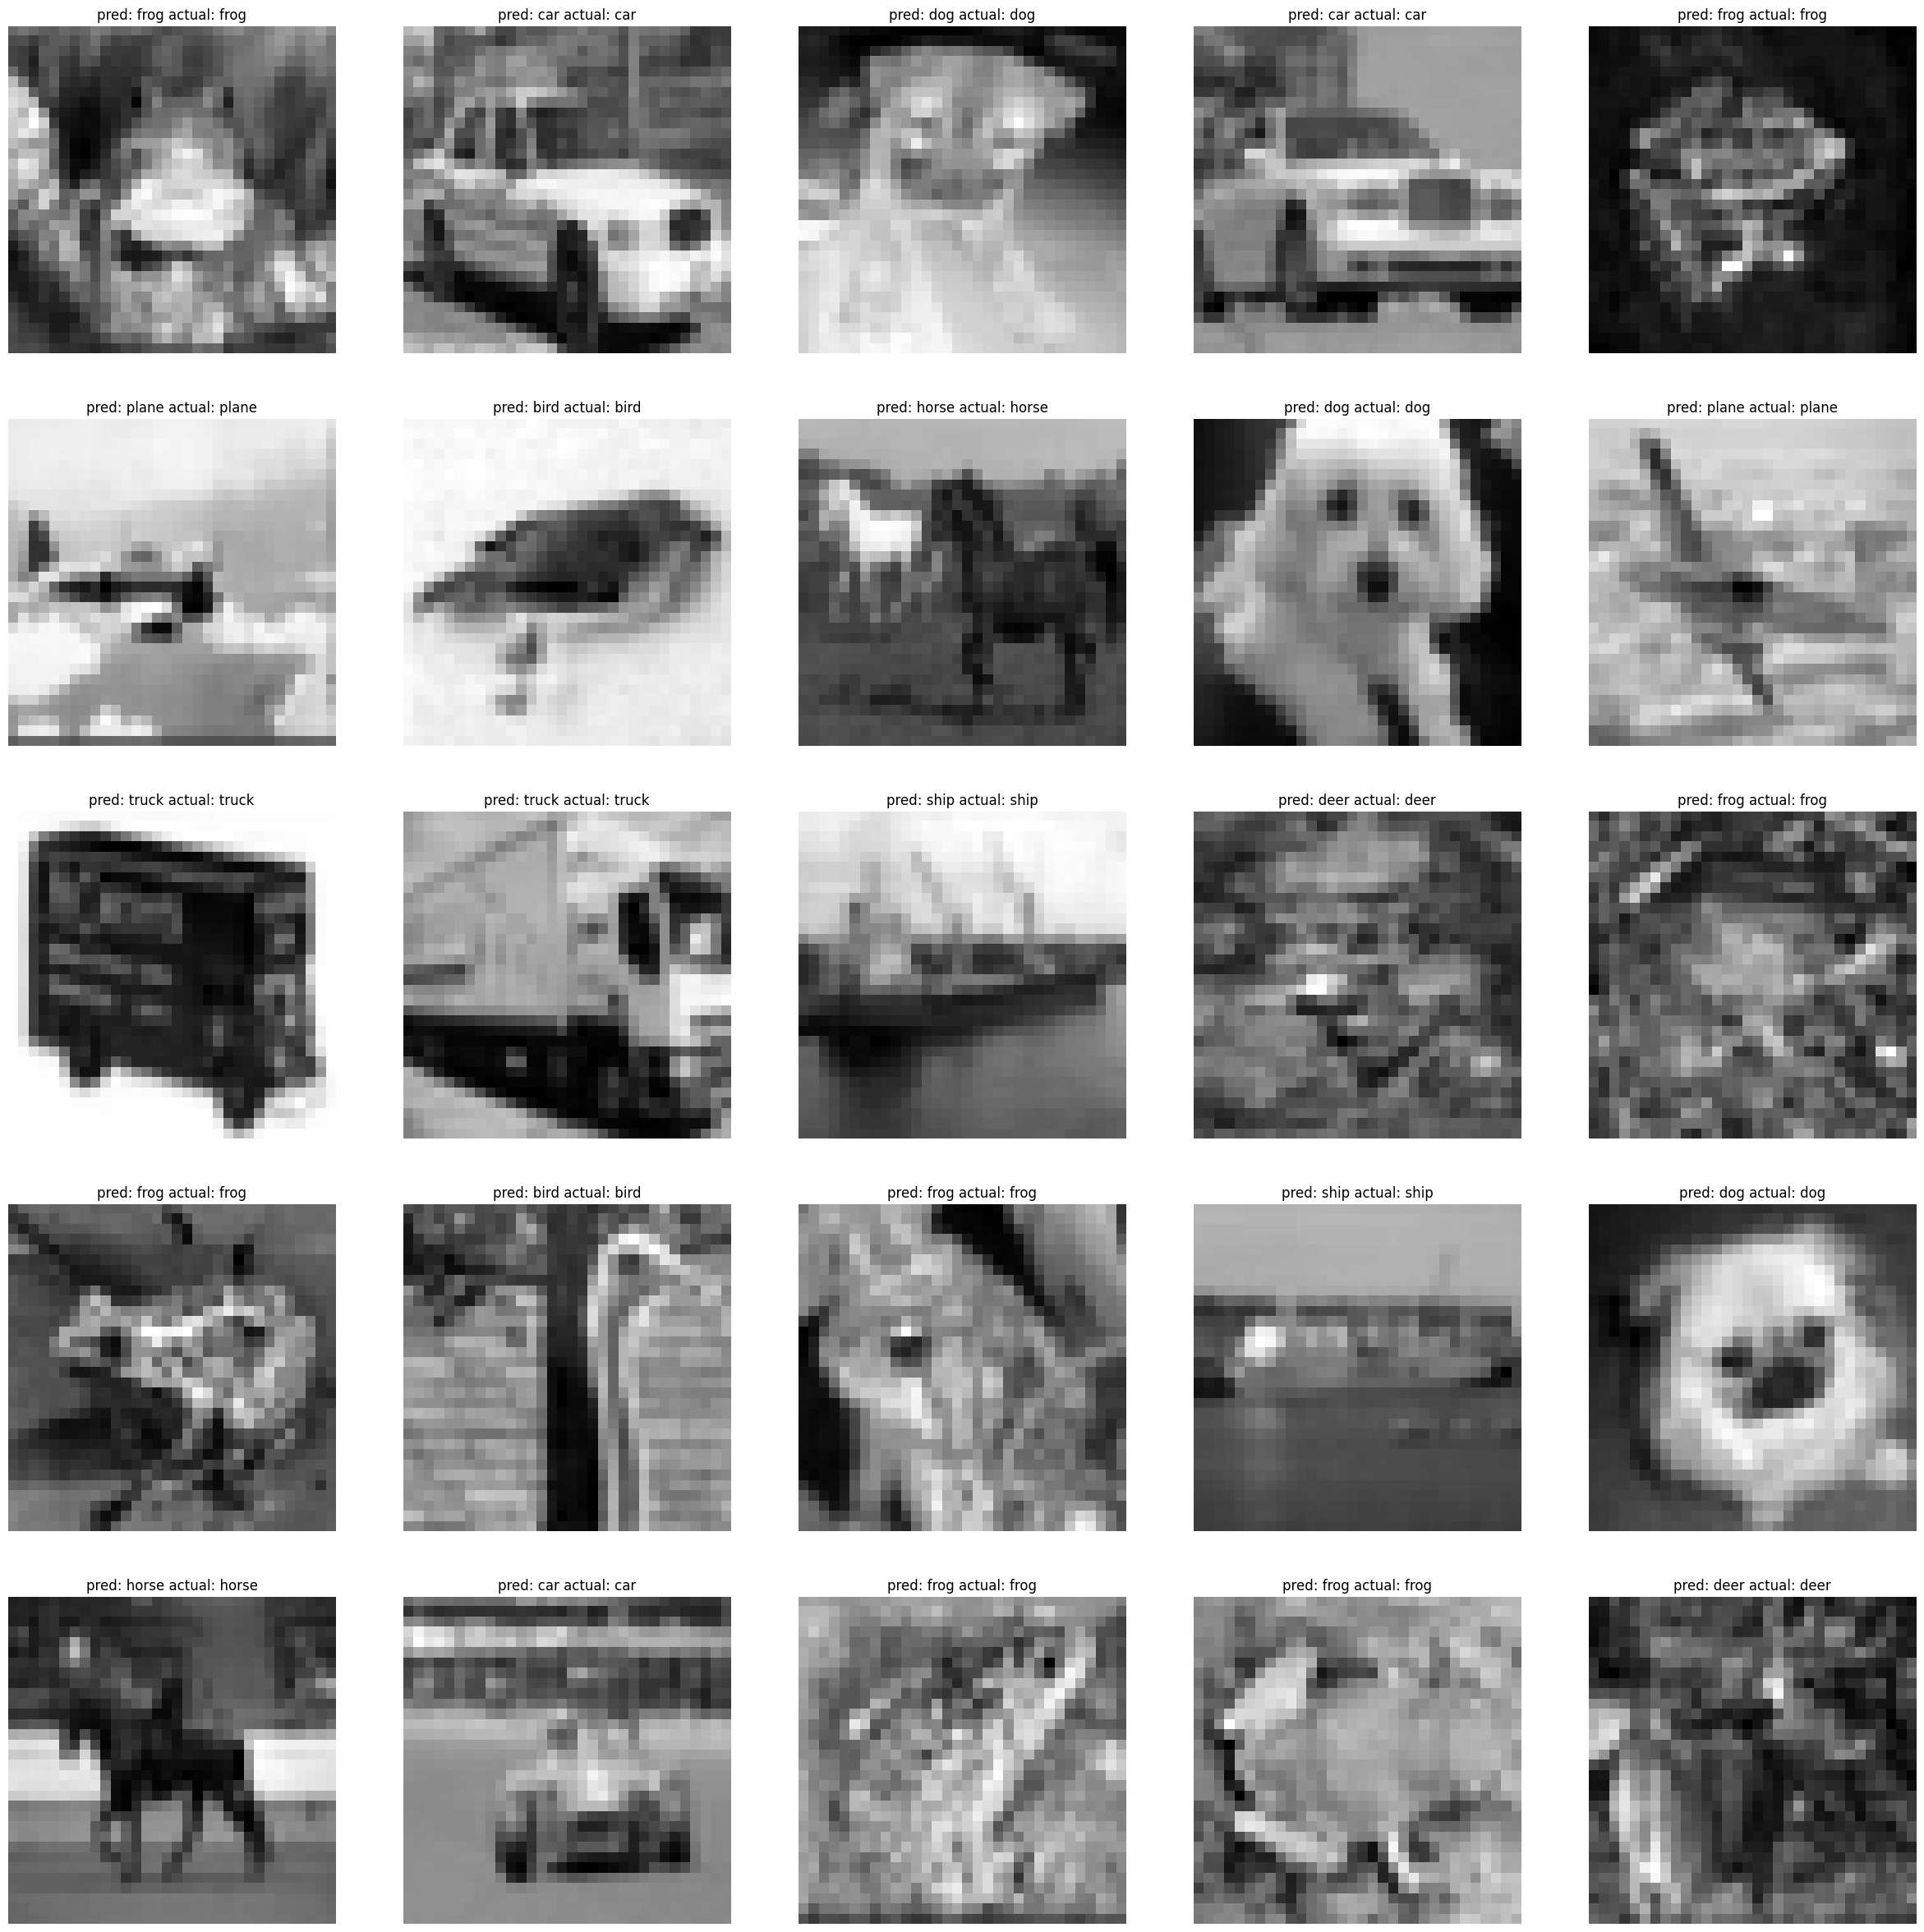

In [17]:
# predict labels
def predict(xb):
    y_hat = model(xb)
    y_hat = torch.argmax(y_hat, dim=1)
    return y_hat

# get predictions
preds = predict(test_data)
preds = preds.numpy()

# get actual labels
actual = test_labels.numpy()

# get indices of misclassified images
misclassified = np.where(preds != actual)[0]
print(misclassified.shape)

# plot misclassified images
fig, ax = plt.subplots(5, 5, figsize=(30, 30))
for i in range(5):
    for j in range(5):
        idx = np.random.choice(misclassified)
        ax[i, j].imshow(test_data[idx].reshape(32, 32), cmap='gray')
        ax[i, j].set_title(f"pred: {classes[preds[idx]]} actual: {classes[actual[idx]]}")
        ax[i, j].axis('off')
plt.show()

# plot correctly classified images
fig, ax = plt.subplots(5, 5, figsize=(30, 30))
for i in range(5):
    for j in range(5):
        idx = np.random.choice(np.where(preds == actual)[0])
        ax[i, j].imshow(test_data[idx].reshape(32, 32), cmap='gray')
        ax[i, j].set_title(f"pred: {classes[preds[idx]]} actual: {classes[actual[idx]]}")
        ax[i, j].axis('off')
plt.show()